# Aprendizado Profundo

# Processamento dos dados

# Redes Generativas Adversárias

# Caso de uso

In [1]:
var = """
TODO: 
- Mostrar imagem do mapa
- Análise estatística para modelagem com ARIMA
""" 

In [37]:
import glob
import importlib
import numpy as np
import pandas as pd
import plotting as p
import matplotlib.pyplot as plt
importlib.reload(p)
from sklearn.preprocessing import MinMaxScaler
plt.style.use("seaborn")

## Leitura e descrição dos dados

In [2]:
bikes = pd.read_csv('datasets/bike_sharing_2011to2019.csv')
bikes.head()

,date,hour,cnt
0,2011-01-01,0,16
1,2011-01-01,1,40
2,2011-01-01,2,32
3,2011-01-01,3,13
4,2011-01-01,4,1


In [4]:
bikes['cnt'].describe()

count    78888.000000
mean       329.480884
std        337.722508
min          0.000000
25%         59.000000
50%        226.000000
75%        487.000000
max       2037.000000
Name: cnt, dtype: float64

TODO: Breve explicação das colunas

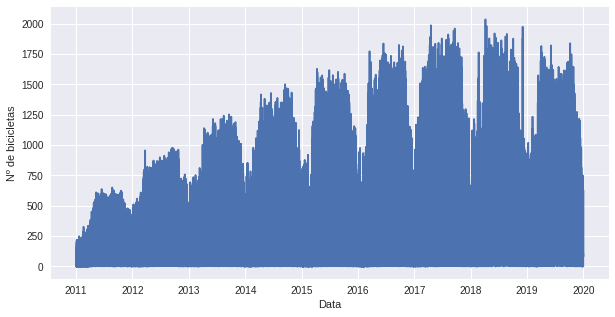

In [3]:
lista_datas = p.get_list_dates(data_size=bikes.shape[0], year=2011, month=1, day=1)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lista_datas, bikes['cnt'])
ax.set_xlabel("Data")
ax.set_ylabel("Nº de bicicletas");
# ax.set_title("Bicicletas alugadas entre 01/01/2011 e 31/12/2019");
# plt.savefig("imagens/analises/bikes_total.eps")

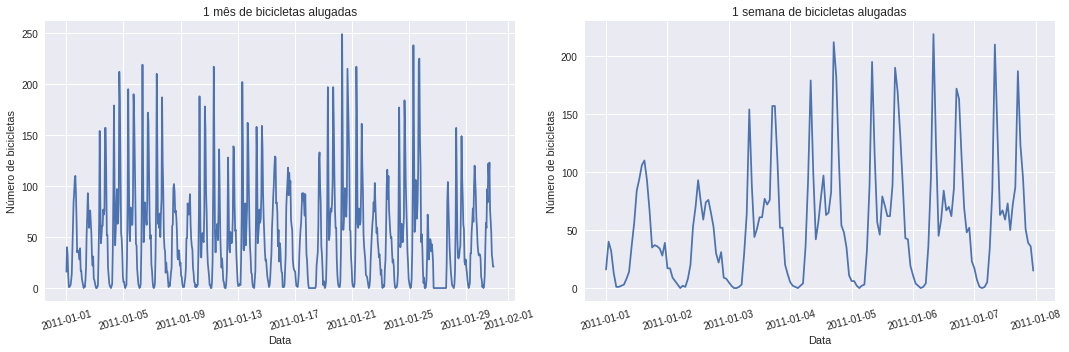

In [17]:
fig, ax = plt.subplots(nCaptioncols=2, figsize=(15,5))
ax[0].plot(lista_datas[:30*24], bikes['cnt'].iloc[:30*24])
ax[0].set_xlabel("Data")
ax[0].set_ylabel("Número de bicicletas")
ax[0].set_title("1 mês de bicicletas alugadas")
ax[0].tick_params('x', labelrotation=15)
ax[1].plot(lista_datas[:7*24], bikes['cnt'].iloc[:7*24])
ax[1].set_xlabel("Data")
ax[1].set_ylabel("Número de bicicletas")
ax[1].set_title("1 semana de bicicletas alugadas")
ax[1].tick_params('x', labelrotation=15)
plt.tight_layout();
plt.savefig("imagens/analises/bike_mes_semana.eps")

## Características esperadas

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


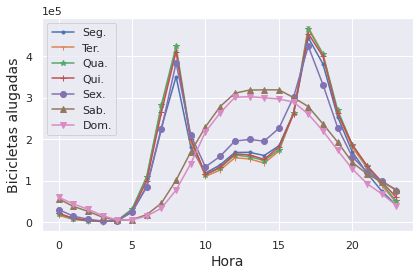

In [14]:
real_data = bikes["cnt"].values.reshape(bikes.shape[0]//24, 24)
df_real = p.get_df(list_dates=lista_datas, data=bikes[["cnt"]].values, timesteps=24)
lista_cnt = [p.get_count(df_real,w,24, column="ts")["cnt_0"] for w in range(7)]
p.plot_sum_real(list_cnt_real=lista_cnt, list_dates=lista_datas)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.tight_layout()
plt.savefig("imagens/analises/bike_somas_intervalos.eps")

## Desafios de modelagem

- TODO: mostrar como sumarização não funciona (gerar dados falsos com a mesma métrica)

In [4]:
path_lista_fakes = glob.glob('datasets/generated/*.npy')

In [55]:
import numpy as np

In [28]:
a = np.load(path_lista_fakes[0])

In [27]:
dict_weeks = {i:p.get_list_wks(path_lista_fakes, lista_datas, 24, wk=i) for i in range(7)}

In [44]:
a = np.array(dict_weeks[0][0])

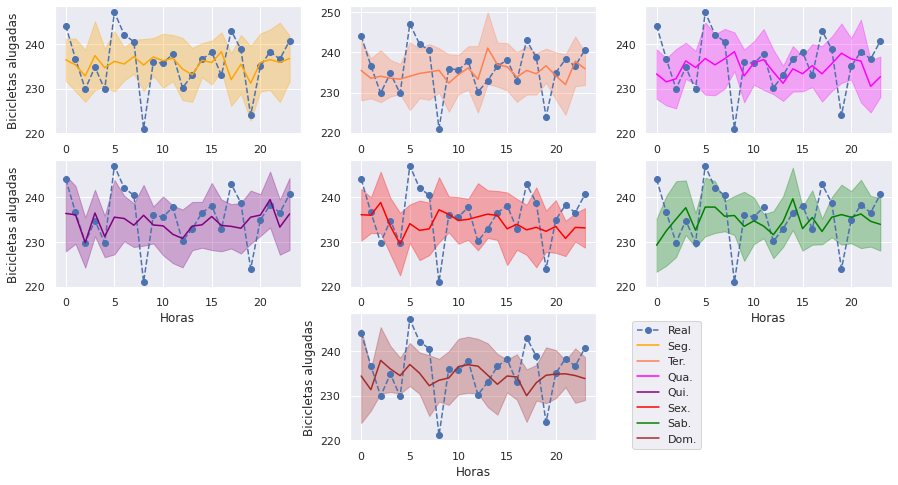

In [68]:
# 0, 3, 6
# 3, 6, 5
p.plot_compare_sum(dict_weeks, a, bbox=(1.45, -0.1))

# Modelagem com o ARIMA

- Verificar se é estacionária
- Aplicar ajustes, se for necessário

In [4]:
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from statsmodels.tsa.arima.model import ARIMA

In [5]:
adf_test = pm.arima.stationarity.ADFTest(alpha=0.05)
treino = bikes['cnt'].iloc[:365*24].values
p_value, dif = adf_test.should_diff(treino)
print(p_value, dif)

0.01 False


In [6]:
%%time
pm_auto = pm.auto_arima(treino, seasonal=True, maxiter=5, start_p=2, max_p=3, start_q=2, max_q=3, stationary=True, m=7)

CPU times: user 4min 13s, sys: 2min 23s, total: 6min 37s
Wall time: 2min 16s


In [7]:
o, so = [pm_auto.order, pm_auto.seasonal_order]
print (o, so)

(1, 0, 3) (1, 0, 2, 7)


In [8]:
# ajusta um modelo arima nos dados de treinamento
arima = ARIMA(treino, order=o, seasonal_order=so)
res = arima.fit()

In [11]:
# gera 10 bases sinteticas com um modelo arima
for i in range(10):
    synth_arima = res.simulate(nsimulations=len(treino))
    np.save('datasets/generated/arima/arima_{}.npy'.format(i), synth_arima)

# GAN

In [ ]:
! pip install ydata-synthetic

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [ ]:
# Specific to TimeGANs
seq_len=24
n_seq = 1
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 28

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [11]:
scaler = MinMaxScaler().fit(treino.reshape(-1,1))
treino_scaled = scaler.transform(treino.reshape(-1,1))
treino_s = treino_scaled.reshape(len(treino)//24, 24, 1)

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(treino_s, train_steps=3000)

In [ ]:
synth.save("modelos/minicurso_bike.pkl")

In [ ]:
for i in range(10):
    synth_data = synth.sample(len(treino_s))
    np.save("datasets/generated/timegan/timegan_{}.npy".format(i), synth_data)

In [15]:
treino_s = MinMaxScaler().fit_transform(treino.reshape(-1,1))
treino_s = treino_s.reshape(treino.shape[0],1)

In [16]:
df_sample = p.get_df(lista_datas[:365*24], treino_s, timesteps=24)
dict_weeks_real = {wk:p.get_count(df_sample,wk,timestep=24, column='ts')['cnt_0'] for wk in range(7)} 

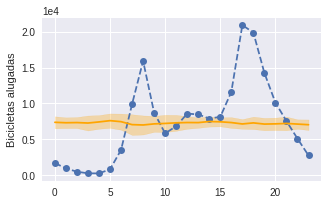

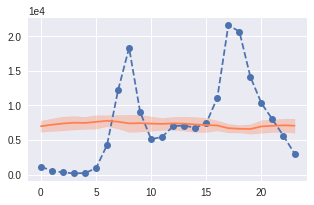

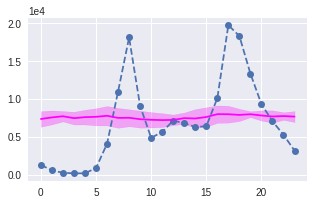

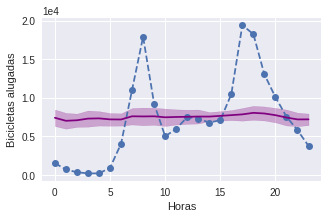

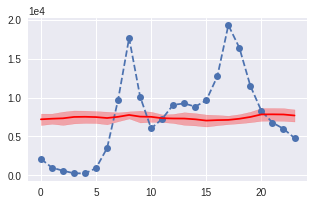

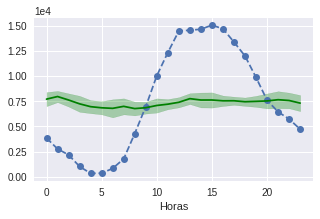

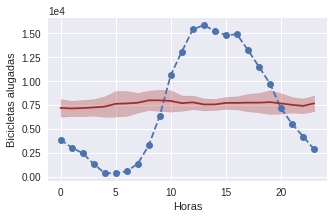

In [38]:
df_sample = p.get_df(lista_datas[:365*24], treino.reshape(-1,1 ), timesteps=24)
dict_weeks_real_arima = {wk:p.get_count(df_sample,wk,timestep=24, column='ts')['cnt_0'] for wk in range(7)} 

path_lista_fakes = glob.glob("datasets/generated/arima/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
# fig, axes = p.plot_compare_sum(dict_weeks_fakes, dict_weeks_real_arima, bbox=(1.45, -0.1), figtitle="".format(o, so), scaler=None)
p.plot_compare_sum2(dict_weeks_fakes, dict_weeks_real_arima, bbox=(1.45, -0.1), figtitle="".format(o, so), scaler=None)

In [31]:
extent.expanded(1,1,1,1)

TypeError: expanded() takes 3 positional arguments but 5 were given

In [24]:
for i, ax2 in enumerate(axes):
    # Save just the portion _inside_ the second axis's boundaries
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig('ax2_figure.png', bbox_inches=extent)

    # Pad the saved area by 10% in the x-direction and 20% in the y-direction
    fig.savefig('imagens/analises/subfigures/arima_ax{}.pdf'.format(i), bbox_inches=extent.expanded(1.1, 1.2))


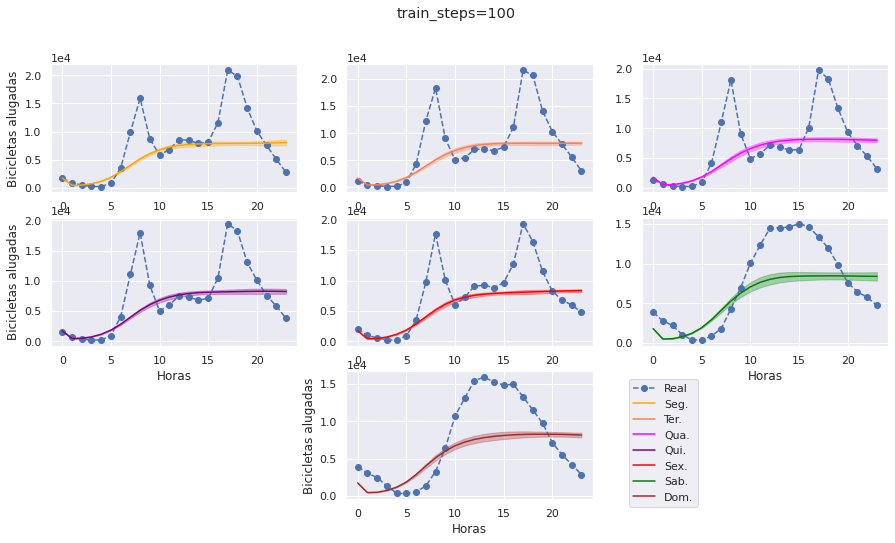

In [24]:
path_lista_fakes = glob.glob("datasets/generated/timegan/1/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), figtitle="train_steps=100", scaler=scaler)

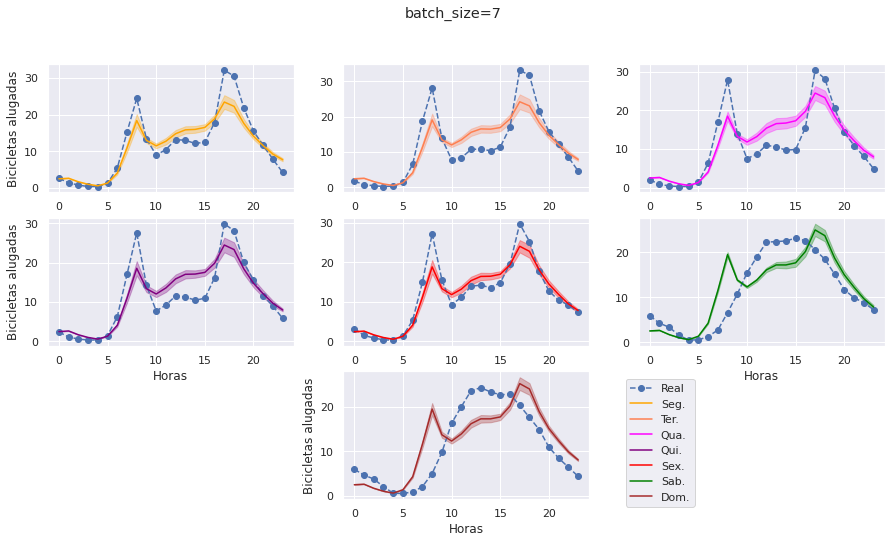

In [16]:
path_lista_fakes = glob.glob("datasets/generated/timegan/2/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes, dict_weeks_real, bbox=(1.45, -0.1), figtitle="batch_size=7")

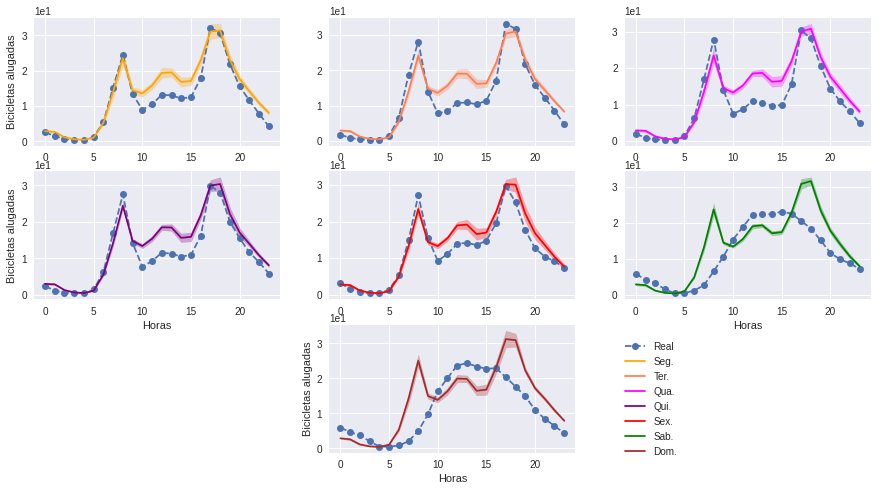

In [19]:
path_lista_fakes = glob.glob("datasets/generated/timegan/3/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), figtitle="")
plt.savefig("imagens/analises/gans_somas.pdf")

## Treinamento

## Avaliação

In [46]:
import residuals as r
importlib.reload(r)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [31]:
rnn_model = r.make_rnn_model(units=32, n_layers=2, net_type='lstm')

2022-07-06 10:51:29.282348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 10:51:29.282375: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 10:51:29.282399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iranlprm): /proc/driver/nvidia/version does not exist


In [27]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 24, 32)            4352      
                                                                 
 LSTM_2 (LSTM)               (None, 32)                8320      
                                                                 
 OUT (Dense)                 (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [32]:
opt = Adam(learning_rate=5e-4)
rnn_model.compile(optimizer=opt, loss='mse')

In [35]:
X, Y = r.split_sequence(treino_s.flatten(),24)
X = X.reshape(X.shape[0],X.shape[1],1)

In [38]:
early_stop = EarlyStopping(monitor='loss')
hist=rnn_model.fit(X,Y,epochs=50,batch_size=28,callbacks=[early_stop])

Epoch 1/50
312/312 [==============================] - 8s 15ms/step - loss: 0.0317
Epoch 2/50
312/312 [==============================] - 5s 17ms/step - loss: 0.0165


In [39]:
synth_m1 = glob.glob("datasets/generated/timegan/1/*.npy")
synth_m2 = glob.glob("datasets/generated/timegan/2/*.npy")
synth_m3 = glob.glob("datasets/generated/timegan/3/*.npy")

In [40]:
X_pred = rnn_model.predict(X)

273/273 [==============================] - 2s 6ms/step


In [41]:
%%time
reid_m1 = [r.get_residuals(f, X_pred) for f in synth_m1]
reid_m2 = [r.get_residuals(f, X_pred) for f in synth_m2]
reid_m3 = [r.get_residuals(f, X_pred) for f in synth_m3]
resid_arima = res.resid

CPU times: user 1.36 s, sys: 1.38 s, total: 2.74 s
Wall time: 3.1 s


In [42]:
%%time
dict_resid = {
    'mu': [ np.mean(resid_arima),  np.mean(reid_m1), np.mean(reid_m2), np.mean(reid_m3)],
    'std': [np.std(resid_arima), np.std(reid_m1), np.std(reid_m2), np.std(reid_m3)]
}

CPU times: user 10.3 s, sys: 4.59 s, total: 14.9 s
Wall time: 16.1 s


In [43]:
df_resid = pd.DataFrame(dict_resid, index=['arima', 'm1', 'm2', 'm3'])

In [44]:
df_resid

,mu,std
arima,-0.008845,64.608229
m1,0.043540,0.197042
m2,-0.012750,0.247794
m3,-0.048837,0.276025


In [27]:
res.resid.mean()

-0.00884502621089828

In [28]:
res.resid.std()

64.60822861039522